# COS80027 Machine Learning
## Assignment 1, 2025, Semester 1
## Student Details:
* Name: Thi Ngan Ha Do
* Student ID: 103128918
* Email: [Student email](mailto:103128918.student.swin.edu.au)
* Submission Date:
* Tutelab Class: Fri 14:30

In [1]:
import string
import re
import pandas as pd
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

## <b>Task 1</b>

### 1.1. Load Data

In [2]:
x_test = pd.read_csv("x_test.csv", header=None)
x_train = pd.read_csv("x_train.csv", header=None)
y_test = pd.read_csv("y_test.csv", header=None)
y_train = pd.read_csv("y_train.csv", header=None)

In [3]:
#Check if data is loaded correctly
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train  shape:", y_train.shape)
print("y_test  shape:", y_test.shape)

x_train shape: (2400, 2)
x_test shape: (600, 2)
y_train  shape: (2400, 1)
y_test  shape: (600, 1)


In [4]:
#Check target distribution
print(y_train[0].value_counts())
print(y_test[0].value_counts())

0
0    1200
1    1200
Name: count, dtype: int64
0
0    300
1    300
Name: count, dtype: int64


### 1.2. Cleaning and Standardisation

In [5]:
def clean(text):
    # Convert to lowercase
    text = str(text).lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text
#Apply cleaning on both train and test set
x_train[1] = x_train[1].apply(clean)
x_test[1]  = x_test[1].apply(clean)

## <b>Task 2</b>

### 2.1. Vectoriser definition and fit

In [6]:
# Keep negation words because they matter for sentiment
negators = {"not", "no", "nor", "never"}

# Subtract negators from scikit‑learn’s built‑in stop‑word set
stop_words = list(ENGLISH_STOP_WORDS.difference(negators))

word_tfidf = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),         # include unigrams + bigrams
    min_df=2,                   # drop words seen in fewer than 2 docs
    max_df=0.7,                 # ignore words in more than 70% of docs
    sublinear_tf=False,         # use raw tf rather than log(tf)
    token_pattern=r"[a-zA-Z]{2,}"  # only keep alphabetic tokens ≥2 letters
)

# Fit/transform word TF‑IDF
x_train_word_tfidf = word_tfidf.fit_transform(x_train[1])
x_test_word_tfidf  = word_tfidf.transform(x_test[1])

In [7]:
# Print final vocabulary terms
print(word_tfidf.get_feature_names_out())
vocab_size = len(word_tfidf.get_feature_names_out())
print(vocab_size)

['ability' 'able' 'absolutely' ... 'yummy' 'zero' 'zero stars']
2111


In [8]:
char_tfidf = TfidfVectorizer(
    stop_words=stop_words,
    analyzer='char',      # switch from words to raw character sequences
    ngram_range=(3, 5),   # keep 3‑, 4‑, and 5‑character substrings
    max_df=0.8,
    sublinear_tf=True     # use log(1 + tf) scaling for counts
)

# Fit/transform char TF‑IDF
x_train_char_tfidf = char_tfidf.fit_transform(x_train[1])
x_test_char_tfidf  = char_tfidf.transform(x_test[1])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [9]:
# One-hot encoding the review domain
domain_ohe = OneHotEncoder()

#Fit/transform the domain one‑hot
x_train_domain = domain_ohe.fit_transform(x_train[[0]])
x_test_domain  = domain_ohe.transform(x_test[[0]])

In [10]:
# Combine into final feature matrices
x_train_combined = hstack([x_train_word_tfidf, x_train_char_tfidf, x_train_domain])
x_test_combined  = hstack([x_test_word_tfidf,  x_test_char_tfidf,  x_test_domain])

print("Train shape:", x_train_combined.shape)
print("Test shape:", x_test_combined.shape)

Train shape: (2400, 56692)
Test shape: (600, 56692)


## <b>Task 3</b>

### 3.1. Transform train / valid / test

In [11]:
# Combine domain and label for stratification
stratify_col = x_train[0].astype(str) + "_" + y_train[0].astype(str)

x_tr, x_val, y_tr, y_val = train_test_split(
    x_train_combined,       # features
    y_train.values.ravel(), # labels (flatten DataFrame)
    test_size=0.20,         # 80/20 split
    stratify=stratify_col,  # preserve class balance
    shuffle=True,
    random_state=11
)

print("Train shape:", x_tr.shape)
print(" Test shape:", x_val.shape)

Train shape: (1920, 56692)
 Test shape: (480, 56692)


### 3.2. Cross‑validation + hyper‑parameter search

#### 80/20 Split

In [12]:
svm = LinearSVC(max_iter=1000)

param_grid = [{
    'C':    [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': ['balanced', None],
    'tol':  [1e-3, 1e-4]
}]

grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid.fit(x_tr, y_tr)
print("Best params:", grid.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'tol': 0.001}


In [13]:
#Search CV value
for k in [3, 5, 10]:
    scores = cross_val_score(svm, x_tr, y_tr, cv=k, scoring='accuracy')
    print(f"CV={k} → Mean: {scores.mean():.4f}, Std: {scores.std():.4f}")

CV=3 → Mean: 0.8240, Std: 0.0128
CV=5 → Mean: 0.8380, Std: 0.0030
CV=10 → Mean: 0.8344, Std: 0.0179


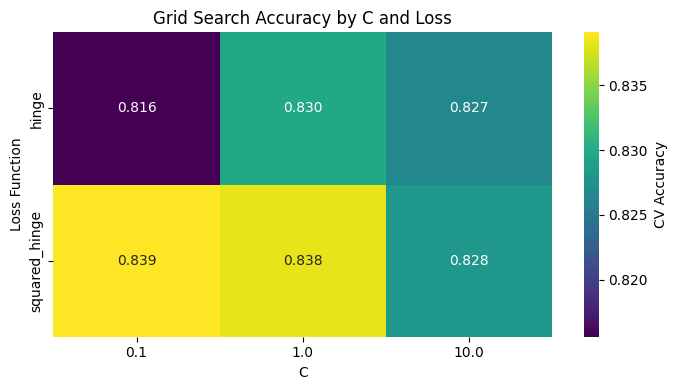

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
results = pd.DataFrame(grid.cv_results_)
heatmap_data = results.pivot_table(
    index="param_loss",  # rows
    columns="param_C",   # columns
    values="mean_test_score"  # cell value = accuracy
)

# Plot heatmap
plt.figure(figsize=(7, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={"label": "CV Accuracy"})

plt.title("Grid Search Accuracy by C and Loss")
plt.xlabel("C")
plt.ylabel("Loss Function")
plt.tight_layout()
plt.show()

In [15]:
best_clf = grid.best_estimator_
y_val_pred = best_clf.predict(x_val)

print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall   :", recall_score(y_val, y_val_pred))
print("F1 score :", f1_score(y_val, y_val_pred))

Confusion matrix:
 [[205  35]
 [ 37 203]]
Accuracy : 0.85
Precision: 0.8529411764705882
Recall   : 0.8458333333333333
F1 score : 0.8493723849372385


In [16]:
best_clf.fit(x_train_combined, y_train.values.ravel())
y_test_pred = best_clf.predict(x_test_combined)

print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall   :", recall_score(y_test, y_test_pred))
print("F1 score :", f1_score(y_test, y_test_pred))

Confusion matrix:
 [[276  24]
 [ 61 239]]
Accuracy : 0.8583333333333333
Precision: 0.908745247148289
Recall   : 0.7966666666666666
F1 score : 0.8490230905861457


#### 90/10 Split

In [17]:
# Create the 90/10 split
x_tr_90, x_val_90, y_tr_90, y_val_90 = train_test_split(
    x_train_combined,
    y_train.values.ravel(),
    test_size=0.10,
    stratify=stratify_col,
    shuffle=True,
    random_state=11
)

print("Train shape (90%):", x_tr_90.shape)
print("Val shape (10%) :", x_val_90.shape)

Train shape (90%): (2160, 56692)
Val shape (10%) : (240, 56692)


In [18]:
# GridSearchCV on 90% train split
svm_90 = LinearSVC(max_iter=1000)
param_grid_90 = [{
    'C':    [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': ['balanced', None],
    'tol':  [1e-3, 1e-4]
}]

grid_90 = GridSearchCV(
    estimator=svm_90,
    param_grid=param_grid_90,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid_90.fit(x_tr_90, y_tr_90)
# Retrieve best model
print("Best params (90% split):", grid_90.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params (90% split): {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'tol': 0.001}


In [19]:
best_clf_90 = grid_90.best_estimator_

# Evaluate on 10% validation split
y_val_pred_90 = best_clf_90.predict(x_val_90)

print("Validation Set Evaluation (10%)")
print("Confusion matrix:\n", confusion_matrix(y_val_90, y_val_pred_90))
print("Accuracy :",  accuracy_score(y_val_90, y_val_pred_90))
print("Precision:",  precision_score(y_val_90, y_val_pred_90))
print("Recall   :",  recall_score(y_val_90, y_val_pred_90))
print("F1 score :",  f1_score(y_val_90, y_val_pred_90))

Validation Set Evaluation (10%)
Confusion matrix:
 [[107  13]
 [ 18 102]]
Accuracy : 0.8708333333333333
Precision: 0.8869565217391304
Recall   : 0.85
F1 score : 0.8680851063829788


In [20]:
# Refit on full training data (100%) and test
best_clf_90.fit(x_train_combined, y_train.values.ravel())
y_test_pred_90 = best_clf_90.predict(x_test_combined)

print("Test Set Evaluation")
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred_90))
print("Accuracy :",  accuracy_score(y_test, y_test_pred_90))
print("Precision:",  precision_score(y_test, y_test_pred_90))
print("Recall   :",  recall_score(y_test, y_test_pred_90))
print("F1 score :",  f1_score(y_test, y_test_pred_90))

Test Set Evaluation
Confusion matrix:
 [[276  24]
 [ 61 239]]
Accuracy : 0.8583333333333333
Precision: 0.908745247148289
Recall   : 0.7966666666666666
F1 score : 0.8490230905861457


### 3.3. Analysis of Predictions for the Classifier

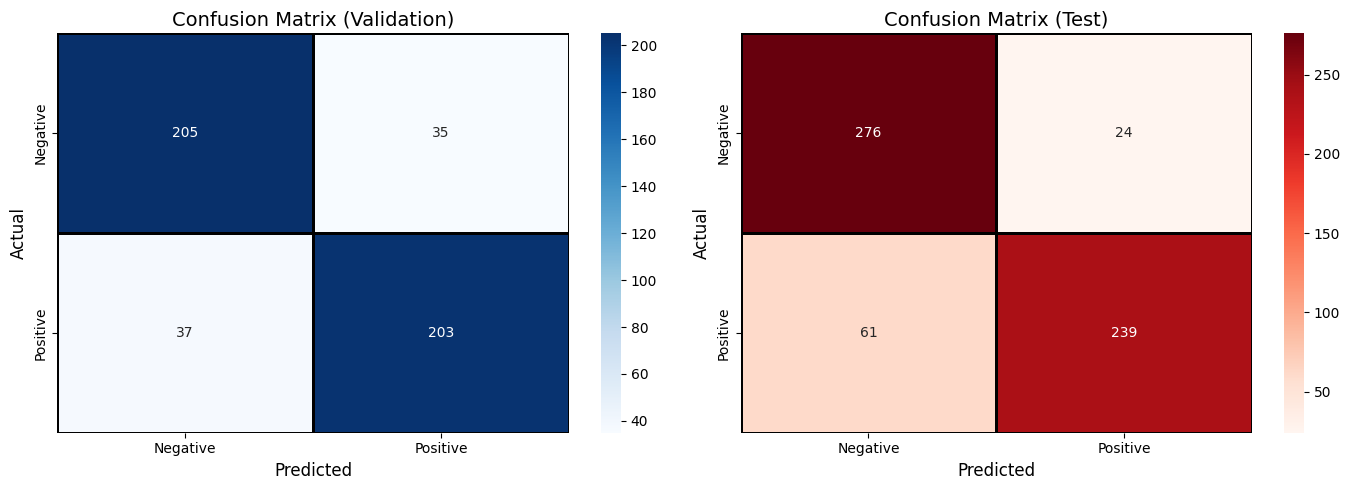

In [21]:
# Compute confusion matrices
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

labels = ['Negative', 'Positive']

plt.figure(figsize=(14, 5))

# --- Validation Confusion Matrix ---
plt.subplot(1, 2, 1)
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            linecolor="k", linewidths=1)
plt.title("Confusion Matrix (Validation)", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

# --- Test Confusion Matrix ---
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Reds",
            xticklabels=labels, yticklabels=labels,
            linecolor="k", linewidths=1)
plt.title("Confusion Matrix (Test)", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)

plt.tight_layout()
plt.show()

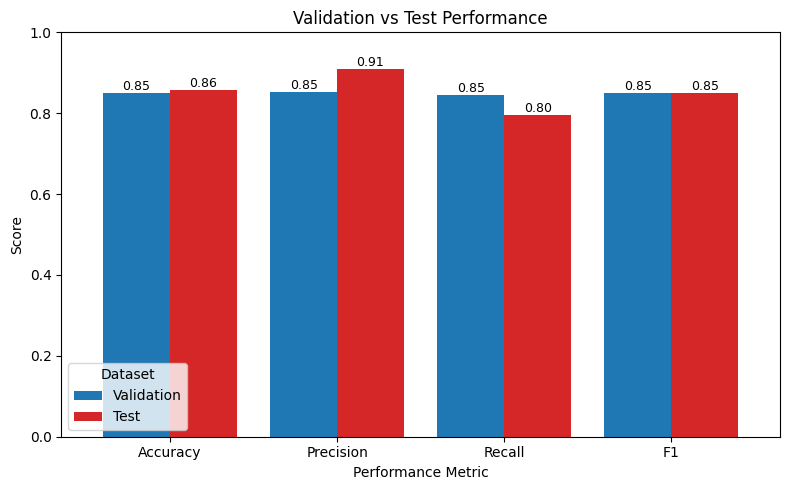

In [22]:
val_metrics = {
    'Accuracy':  accuracy_score(y_val, y_val_pred),
    'Precision': precision_score(y_val, y_val_pred),
    'Recall':    recall_score(y_val, y_val_pred),
    'F1':        f1_score(y_val, y_val_pred)
}

test_metrics = {
    'Accuracy':  accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall':    recall_score(y_test, y_test_pred),
    'F1':        f1_score(y_test, y_test_pred)
}

# Create DataFrame
metrics_df = pd.DataFrame([val_metrics, test_metrics],
                          index=['Validation','Test'])

# Transpose for side-by-side bars
metrics_t = metrics_df.T.rename(columns={'F1': 'F1 Score'})

# Custom colors: match confusion matrix styles
colors = ['#1f77b4', '#d62728']  # blue, red

# Plot
ax = metrics_t.plot(
    kind='bar',
    figsize=(8, 5),
    rot=0,
    width=0.8,
    color=colors
)

ax.set_title("Validation vs Test Performance")
ax.set_xlabel("Performance Metric")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.legend(title="Dataset")

# Annotate each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}",
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

<ipython-input-23-87d357b564b4>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups.values(), labels=groups.keys(), showfliers=True)


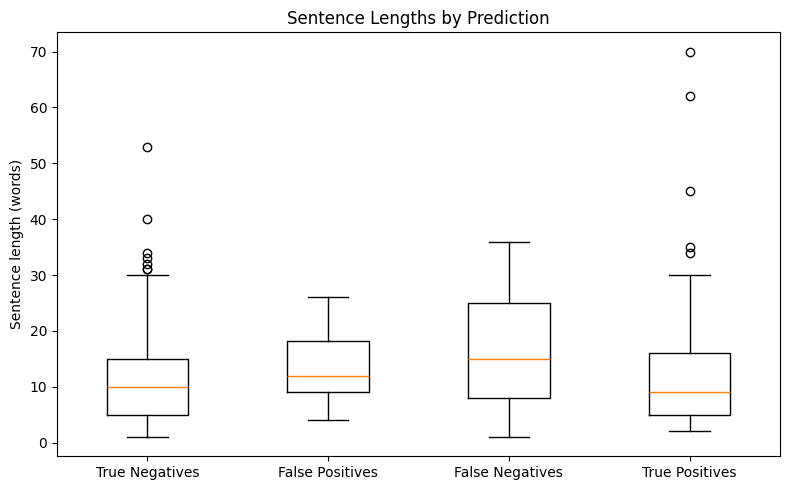

In [23]:
y_test_series = y_test.iloc[:,0] if isinstance(y_test, pd.DataFrame) else pd.Series(y_test)

# Compute sentence lengths:
lengths = x_test[1].str.split().str.len()

# Group into the four categories:
groups = {
    'True Negatives':  lengths[(y_test_series == 0) & (y_test_pred == 0)],
    'False Positives': lengths[(y_test_series == 0) & (y_test_pred == 1)],
    'False Negatives': lengths[(y_test_series == 1) & (y_test_pred == 0)],
    'True Positives':  lengths[(y_test_series == 1) & (y_test_pred == 1)]
}

# Plot a boxplot:
plt.figure(figsize=(8,5))
plt.boxplot(groups.values(), labels=groups.keys(), showfliers=True)
plt.ylabel('Sentence length (words)')
plt.title('Sentence Lengths by Prediction')
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(False)
plt.show()

<ipython-input-24-45dead6f091a>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  domain_accuracy = test_df.groupby("domain").apply(


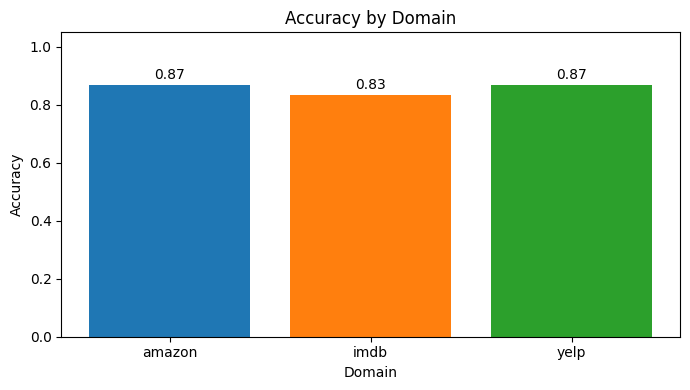

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine domain, review, true, and predicted labels
test_df = x_test.copy()
test_df.columns = ["domain", "review"]  # Rename if needed
test_df["true"] = y_test
test_df["pred"] = y_test_pred

# Group by domain and compute accuracy
domain_accuracy = test_df.groupby("domain").apply(
    lambda df: (df["true"] == df["pred"]).mean()
).reset_index(name="accuracy")

import matplotlib.pyplot as plt

# Color palette
domain_colors = {
    "amazon": "#1f77b4",
    "imdb": "#ff7f0e",
    "yelp": "#2ca02c"
}

# Match colors to domain order in DataFrame
colors = [domain_colors.get(domain, "#999999") for domain in domain_accuracy["domain"]]

# Plot
plt.figure(figsize=(7, 4))
bars = plt.bar(domain_accuracy["domain"], domain_accuracy["accuracy"], color=colors)

# Annotate bars
for bar, acc in zip(bars, domain_accuracy["accuracy"]):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 0.01,
             f"{acc:.2f}", ha="center", va="bottom", fontsize=10)

# Style
plt.title("Accuracy by Domain")
plt.xlabel("Domain")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-25-86fc0c48322b>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = test_df.groupby("has_negation").apply(compute_group_stats).reset_index()


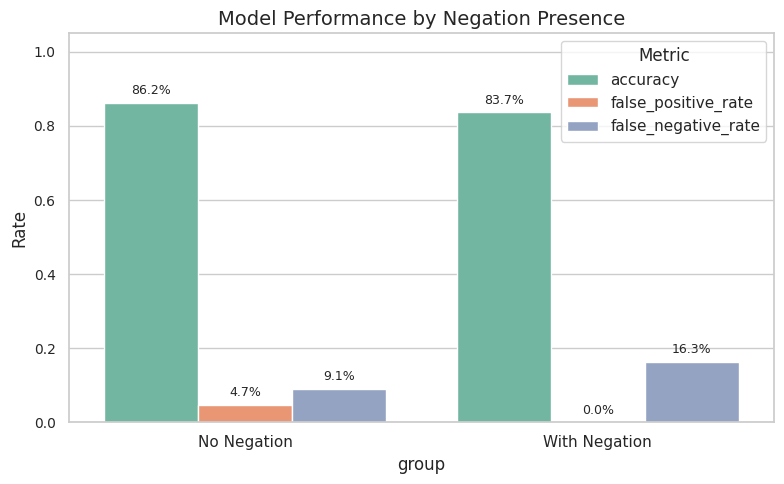

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define list of negation words
negation_words = {"not", "no", "never", "nor", "n't", "didn't", "shouldn't", "couldn't", "wasn't", "don't"}

# Function to check for negation
def contains_negation(text):
    tokens = str(text).lower().split()
    return any(neg in tokens for neg in negation_words)

# Combine predictions with test set
test_df = x_test.copy()
test_df["true"] = y_test
test_df["pred"] = y_test_pred

# Add negation presence column
test_df["has_negation"] = test_df[1].apply(contains_negation)

# Function to compute stats
def compute_group_stats(df):
    total = len(df)
    accuracy = (df["true"] == df["pred"]).mean()
    false_pos = ((df["true"] == 0) & (df["pred"] == 1)).sum() / total
    false_neg = ((df["true"] == 1) & (df["pred"] == 0)).sum() / total
    return pd.Series({
        "accuracy": accuracy,
        "false_positive_rate": false_pos,
        "false_negative_rate": false_neg,
        "count": total
    })

# Group by negation presence
summary = test_df.groupby("has_negation").apply(compute_group_stats).reset_index()
summary["group"] = summary["has_negation"].map({True: "With Negation", False: "No Negation"})

# Melt the dataframe to long-form for seaborn
plot_data = summary.melt(
    id_vars=["group", "count"],
    value_vars=["accuracy", "false_positive_rate", "false_negative_rate"],
    var_name="Metric",
    value_name="Value"
)

# Set plot style
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=plot_data,
    x="group",
    y="Value",
    hue="Metric",
    palette=["#66c2a5", "#fc8d62", "#8da0cb"]
)

# Annotate each bar
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.annotate(
            f'{height * 100:.1f}%',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 4),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=9
        )

# Formatting
plt.ylim(0, 1.05)
plt.title("Model Performance by Negation Presence", fontsize=14)
plt.ylabel("Rate", fontsize=12)
plt.legend(title="Metric", loc="upper right")
plt.xticks(fontsize=11)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()